In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias
from exp_hp import get_hp

2025-01-28 10:28:04.630898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 10:28:06.376621: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Test NN

In [3]:
#----- SET UP & TRAIN NN -----
EXP_NAME = 'exp2_kfold'
hps = get_hp(EXP_NAME)
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

all_confcutoffs = []
for kk in range(20):
    print('Training Members: '+str(hps['train_mems'][kk]))
    print('Validation Member: '+str(hps['val_mems'][kk][0]))
    print('Testing Member: '+str(hps['test_mems'][kk][0]))
    
    
    _, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'][kk],
                                                      valmem = hps['val_mems'][kk][0],
                                                      testmem = hps['test_mems'][kk][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) 
    
    X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))
    
    
    acc_all = []
    for SEED in range(10):
        annfi_name = 'ann_60Eshift_'+EXP_NAME+'.'+str(kk)+'_seed'+str(SEED)+'.h5' 
        ann = tf.keras.models.load_model(base_dir+'train/saved_models/kfold/'+annfi_name)
        
        pred = ann.predict(X1test)
        acc = []
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)

        q = 80
        all_confcutoffs.append(np.percentile(predconf,q=q))
    #     for q in range(100):
    #         iconf = np.where(predconf >= np.percentile(predconf,q=q))
    #         icorr = np.where(predval[iconf] == Y1test[iconf])
            
    #         acc.append((len(icorr[0])/len(iconf[0]))*100)
    #     plt.plot(acc)
        
    #     acc_all.append(acc)
    # plt.show()
    
    # np.save(base_dir+'test/confvsacc/kfold/confvsacc_ann1_60Eshift_'+EXP_NAME+'.'+str(kk)+'.npy', acc_all, allow_pickle=True)

Training Members: ['0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181', '0191']
Validation Member: 0201
Testing Member: 0101
files do not exist - loading data & saving


2025-01-28 10:29:35.390451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 0s 1ms/step
Training Members: ['0121', '0131', '0141', '0151', '0161', '0171', '0181', '0191', '0201']
Validation Member: 0211
Testing Member: 0111
files do not exist - loading data & saving
223/223 [==============================] - 0s 1ms/step
Training Members: ['0131', '0141', '0151', '0161', '0171', '0181', '0191', '0201', '0211']
Validation Member: 0221
Testing Member: 0121
files do not exist - loading data & saving
239/239 [==============================] - 0s 1ms/step
Training Members: ['0141', '0151', '0161', '0171', '0181', '0191', '0201', '0211', '0221']
Validation Member: 0231
Testing Member: 0131
files do not exist - loading data & saving
231/231 [==============================] - 0s 1ms/step
Training Members: ['0151', '0161', '0171', '0181', '0191', '0201', '0211', '0221', '0231']
Validation Member: 0241
Testing Member: 0141
files do not exist - loading data & saving
234/234 [==============================] - 0s 1ms/step
Training 

In [6]:
print(np.min(all_confcutoffs))
print(np.max(all_confcutoffs))
print(np.mean(all_confcutoffs))
print(np.median(all_confcutoffs))

0.5732986927032471
0.6716222167015076
0.6034957720637322
0.6021493434906006


(array([23., 43., 37., 42., 26., 20.,  6.,  2.,  0.,  1.]),
 array([0.57329869, 0.58313105, 0.5929634 , 0.60279575, 0.6126281 ,
        0.62246045, 0.63229281, 0.64212516, 0.65195751, 0.66178986,
        0.67162222]),
 <BarContainer object of 10 artists>)

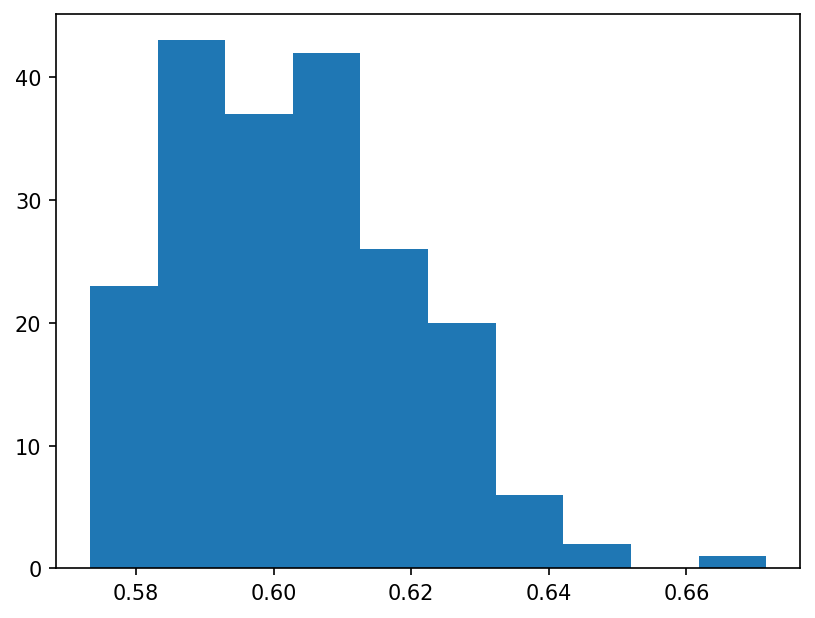

In [4]:
plt.hist(all_confcutoffs)